In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import h5py

In [33]:
with h5py.File('/work/hmzhao/irregular-lc/roman-0-8dof-located-logsig.h5', mode='r') as dataset_file:
    Y = torch.tensor(dataset_file['Y'][...])
    X_even = torch.tensor(dataset_file['X_even'][...])
    X_rand = torch.tensor(dataset_file['X_random'][...])

# preprocess
nanind = torch.where(~torch.isnan(X_even[:, 0, 1]))[0]
Y = Y[nanind]

# discard uncertainty bar
X_even = X_even[nanind]
X_rand = X_rand[nanind]

print(len(Y))
# nanind = torch.where(Y[:, 4]>1e-4)[0]
# Y = Y[nanind]
# X_even = X_even[nanind]
# X_rand = X_rand[nanind]
# print(len(Y))

10000


tensor([4.2397e+01, 6.7652e+00, 9.5813e-02, 2.5359e-04, 7.5724e-01, 9.0358e-01,
        1.6124e+01, 1.2622e-01], dtype=torch.float64)


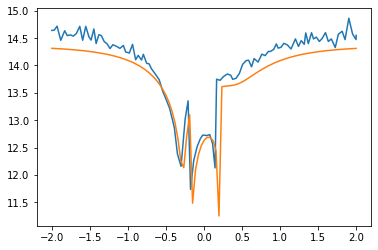

tensor([1.9988, 1.9988, 1.9988, 1.9988, 1.9988], dtype=torch.float64)
torch.Size([10000, 134, 5]) torch.Size([10000, 134, 5])


In [34]:
num = 0
print(Y[num])
# plt.xlim(-1.5, -0.5)
plt.plot(X_rand[num, :, 0], X_rand[num, :, 1])
plt.plot(X_even[num, :, 0], X_even[num, :, 1])
plt.show()
print(X_even[num, -5:, 0])
print(X_even.shape, X_rand.shape)

# CDE-MDN

In [18]:
import torchcde
with h5py.File('/work/hmzhao/irregular-lc/random-even-batch-1.h5', mode='r') as dataset_file:
    Y = torch.tensor(dataset_file['Y'][...])
    X_even = torch.tensor(dataset_file['X_even'][...])
    X_rand = torch.tensor(dataset_file['X_random'][...])
print(Y.shape)
# filter nan
nanind = torch.where(~torch.isnan(X_even[:, 0, 1]))[0]
Y = Y[nanind]
X_even = X_even[nanind]
X_rand = X_rand[nanind]
Y[:, 3:6] = torch.log10(Y[:, 3:6])
Y = torch.hstack([Y, torch.sin(Y[:, [6]] / 180 * np.pi)])
Y[:, 6] = torch.cos(Y[:, 6] / 180 * np.pi)
print(Y.shape)
Y = Y[:, 2:]
print(Y.shape)
mean_y = torch.mean(Y, axis=0)
std_y = torch.std(Y, axis=0)
# std_mask = (std_y==0)
# std_y[std_mask] = 1
print(f'Y mean: {mean_y}\nY std: {std_y}')
mean_x_even = 14.5
std_x_even = 0.2
# X_even[:, :, 1] = 10**((22-X_even[:, :, 1])/2.5)/1000
# X_even[:, :, 1] = 22 - 2.5*torch.log10(1000*X_even[:, :, 1])
X_even[:, :, 1] = (X_even[:, :, 1] - mean_x_even) / std_x_even
X_rand[:, :, 1] = (X_rand[:, :, 1] - mean_x_even) / std_x_even
print(f'normalized X mean: {torch.mean(X_even[:, :, 1])}\nX std: {torch.mean(torch.std(X_even[:, :, 1], axis=0))}')

# time rescale
X_even[:, :, 0] = X_even[:, :, 0] / 200
X_rand[:, :, 0] = X_rand[:, :, 0] / 200
X_rand = X_rand[:, :, :2]
    
# CDE interpolation with log_sig
depth = 3; window_length = 10; window_length_rand = 2
train_logsig = torchcde.logsig_windows(X_even, depth, window_length=window_length)
train_coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(train_logsig)
train_logsig_rand = torchcde.logsig_windows(X_rand, depth, window_length=window_length_rand)
train_coeffs_rand = torchcde.hermite_cubic_coefficients_with_backward_differences(train_logsig_rand)

torch.Size([100000, 7])
torch.Size([100000, 8])
torch.Size([100000, 6])
Y mean: tensor([ 0.4055, -3.0007, -0.9316,  0.0611, -0.0036,  0.0157],
       dtype=torch.float64)
Y std: tensor([0.2958, 0.5779, 0.6977, 0.2436, 0.7128, 0.7012], dtype=torch.float64)
normalized X mean: -2.0646457695410256
X std: 1.1980351190055827


In [35]:
# Y: t_0, t_E, u_0, rho, q, s, alpha, f_s
Y[:, 3:6] = torch.log10(Y[:, 3:6])
Y[:, 6] = torch.cos(Y[:, 6] / 180 * np.pi)
Y[:, 7] = torch.sin(Y[:, 6] / 180 * np.pi)
Y = Y[:, 2:]
mean_y = torch.mean(Y, axis=0)
std_y = torch.std(Y, axis=0)

In [36]:
mean_x_even = 14.5
std_x_even = 0.2
# X_even[:, :, 1] = 10**((22-X_even[:, :, 1])/2.5)/1000
# X_even[:, :, 1] = 22 - 2.5*torch.log10(1000*X_even[:, :, 1])
X_even[:, :, 1] = (X_even[:, :, 1] - mean_x_even) / std_x_even
print(f'normalized X mean: {torch.mean(X_even[:, :, 1])}\nX std: {torch.mean(torch.std(X_even[:, :, 1], axis=0))}')
# X_rand = X_rand[:, :, :2]
# X_rand[:, :, 1] = 10**((22-X_rand[:, :, 1])/2.5)/1000
# X_rand[:, :, 1] = 22 - 2.5*torch.log10(1000*X_rand[:, :, 1])
X_rand[:, :, 1] = (X_rand[:, :, 1] - mean_x_even) / std_x_even

# time rescale
X_even[:, :, 0] = X_even[:, :, 0] / 4
X_rand[:, :, 0] = X_rand[:, :, 0] / 4

normalized X mean: -1.8614091520069842
X std: 1.5575743876676265


In [37]:
from model.locator import Locator
import torchcde
import os
train_coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(X_even)
train_rand_coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(X_rand)

In [4]:
from model.cde_mdn import CDE_MDN
import torchcde
import os

device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")

checkpt = torch.load('/work/hmzhao/experiments/cde_mdn/experiment_31087.ckpt', map_location='cpu')
ckpt_args = checkpt['args']
state_dict = checkpt['state_dict']

output_dim = Y.shape[-1]
input_dim = train_logsig.shape[-1]
# input_dim = X_even.shape[-1]
latent_dim = ckpt_args.latents

model = CDE_MDN(input_dim, latent_dim, output_dim).to(device)
model_dict = model.state_dict()

# 1. filter out unnecessary keys
state_dict = {k: v for k, v in state_dict.items() if k in model_dict}
# 2. overwrite entries in the existing state dict
model_dict.update(state_dict) 
# 3. load the new state dict
model.load_state_dict(state_dict)
model.to(device)

CDE_MDN(
  (cde_func): CDEFunc(
    (linear1): Linear(in_features=32, out_features=1024, bias=True)
    (relu1): PReLU(num_parameters=1)
    (resblocks): Sequential(
      (0): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): PReLU(num_parameters=1)
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (1): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): PReLU(num_parameters=1)
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (2): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): PReLU(num_parameters=1)
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
    )
    (relu2): PReLU(num_parameters=1)
    (linear2): Linear(in_features=1024, out_features=160, bias=True)
    (tanh): Tanh()
    (linear3): Linear(in_features=

In [17]:
from tqdm.notebook import tqdm
num = 4096
batchsize = 64
pred = torch.zeros((num, 6))
pred_rand = torch.zeros((num, 6))
model.eval()
for i in tqdm(range(num // batchsize)):
    batch = train_coeffs[i*batchsize:i*batchsize+batchsize].float().to(device)
    batch_rand = train_coeffs_rand[i*batchsize:i*batchsize+batchsize].float().to(device)
    pi, normal = model(batch)
    pred[i*batchsize:i*batchsize+batchsize] = model.sample(pi, normal).detach().cpu()
    pi, normal = model(batch_rand)
    pred_rand[i*batchsize:i*batchsize+batchsize] = model.sample(pi, normal)
    

  0%|          | 0/64 [00:00<?, ?it/s]

In [18]:
torch.mean((pred-Y[:num])**2, dim=0), torch.mean((pred_rand-Y[:num])**2, dim=0)

(tensor([2.3880e-02, 6.6600e-01, 1.1418e-01, 2.3351e-02, 2.9159e-01, 1.1529e-04],
        dtype=torch.float64),
 tensor([2.4113e-02, 6.8977e-01, 1.5830e-01, 3.2164e-02, 3.6832e-01, 1.2440e-04],
        dtype=torch.float64))

In [19]:
num=6
pi, normal = model(train_coeffs[[num]].float().to(device))

In [20]:
from tqdm.notebook import tqdm
grid = torch.stack(torch.meshgrid(torch.linspace(-4, 0, 100), torch.linspace(-0.6, 0.6, 100)), dim=-1).reshape(-1, 2)
prob = torch.zeros(10000, 1)
y = torch.tile(Y[[num]], [10000, 1])
y[:, 2:4] = grid
for i in tqdm(range(10000)):
    prob[i] = torch.exp(-model.mdn_loss(pi, normal, y[[i]].to(device)).detach().cpu())

  0%|          | 0/10000 [00:00<?, ?it/s]

In [21]:
pi.probs

tensor([[3.4657e-06, 2.2097e-05, 9.3261e-01, 2.1996e-07, 1.6720e-06, 3.9578e-04,
         2.6677e-04, 5.3479e-05, 9.3627e-07, 6.0036e-07, 6.6640e-02, 6.2375e-06]],
       device='cuda:7', grad_fn=<SoftmaxBackward>)

In [22]:
Y[num], pred[num]

(tensor([ 0.6907, -3.2307, -0.3903,  0.4580, -0.4708, -0.0082],
        dtype=torch.float64),
 tensor([ 0.7046, -2.6992, -0.3507,  0.4070, -0.4589, -0.0069]))

In [23]:
normal.loc, normal.scale

(tensor([[[ 3.6796e-01, -2.2148e+00, -1.8257e+00,  2.8898e-01,  1.6743e-01,
            7.0889e-02],
          [ 5.8918e-01, -3.0384e+00, -1.8384e-01,  3.4303e-01,  5.9872e-01,
            1.3816e-02],
          [ 6.3372e-01, -3.1313e+00, -3.9289e-01,  4.4620e-01, -5.4698e-01,
           -9.6007e-03],
          [ 2.9073e-01, -1.2634e+00, -3.5817e-01,  3.1077e-01,  3.3836e-01,
            2.0402e-05],
          [ 2.3462e-01, -2.1941e+00, -3.8068e-01,  4.4675e-01, -2.6039e-01,
            5.7493e-02],
          [ 5.5331e-01, -2.8862e+00, -3.5552e-02,  3.0060e-01,  3.0473e-01,
           -7.9173e-03],
          [ 3.1630e-01, -3.0658e+00, -1.0645e-01,  3.7192e-01,  1.9944e-01,
           -2.4467e-02],
          [-5.7516e-01, -2.8111e+00, -2.4040e+00,  1.0625e-01, -6.4934e-02,
            7.5701e-03],
          [ 2.0100e-01, -8.9774e-01, -4.3891e-01,  2.7005e-02,  8.3222e-02,
            3.9641e-02],
          [ 7.0278e-02, -3.5981e-01, -1.3994e-01, -2.5029e-02, -3.9038e-02,
           -1.6

In [24]:
torch.exp(-model.mdn_loss(pi, normal, Y[[num]].to(device)).detach().cpu())

tensor(68526.0178, dtype=torch.float64)

tensor([ 0.6907, -3.2307, -0.3903,  0.4580, -0.4708, -0.0082],
       dtype=torch.float64)


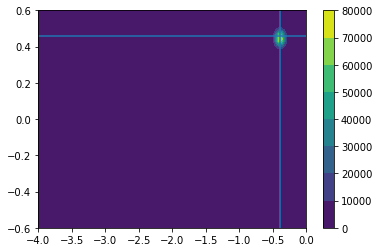

In [25]:
# plt.imshow(prob.reshape(100, 100), origin='lower')
plt.contourf(torch.linspace(-4, 0, 100), torch.linspace(-0.6, 0.6, 100), prob.reshape(100, 100).T)
plt.hlines(Y[num, 3], -4, 0)
plt.vlines(Y[num, 2], -0.6, 0.6)
plt.colorbar()
print(Y[num])

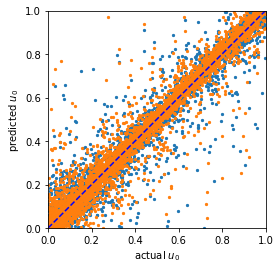

tensor([0.5001, 0.4230, 0.8328, 0.0363, 0.7537, 0.1965, 0.6907, 0.0140, 0.2746,
        0.1172], dtype=torch.float64)
[ 0.5404165   0.44728032  0.767398    0.07451062  0.73865104  0.18084836
  0.7046139  -0.06680586  0.96964955  0.11951245]
mse of u_0:  0.023880028304936934
mse of rand u_0:  0.024112716560003817


In [30]:
import matplotlib.pyplot as plt
%matplotlib inline
num=4096
plt.axis('square')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel(r'actual $u_0$')
plt.ylabel(r'predicted $u_0$')
plt.scatter(Y[:num, 0], pred_rand.numpy()[:num, 0], s=5, alpha=1)
plt.scatter(Y[:num, 0], pred.numpy()[:num, 0], s=5, alpha=1)
plt.plot(np.linspace(0, 1), np.linspace(0, 1), color='b', linestyle='dashed')
plt.show()
print(Y[:10, 0])
print(pred.numpy()[:10, 0])
print('mse of u_0: ', torch.mean((Y[:num, 0] -  pred.numpy()[:num, 0])**2, dim=0).detach().cpu().item())
print('mse of rand u_0: ', torch.mean((Y[:num, 0] -  pred_rand.numpy()[:num, 0])**2, dim=0).detach().cpu().item())

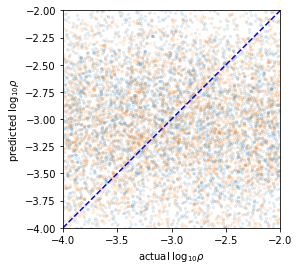

tensor([-2.0703, -3.5956, -2.4052, -3.3257, -2.6564, -3.0041, -3.2307, -3.5376,
        -2.1660, -2.6061], dtype=torch.float64)
[-2.705906  -2.6970444 -4.189402  -2.9656885 -2.444244  -2.7346835
 -2.6992433 -1.11672   -3.1011214 -2.3827486]
mse of log10rho:  0.6660046003908616
mse of rand log10rho:  0.6897717070164799


In [31]:
import matplotlib.pyplot as plt
%matplotlib inline
# num=4096
plt.axis('square')
plt.xlim(-4, -2)
plt.ylim(-4, -2)
plt.xlabel(r'actual $\log_{10}\rho$')
plt.ylabel(r'predicted $\log_{10}\rho$')
plt.scatter(Y[:num, 1], pred_rand.numpy()[:num, 1], s=5, alpha=0.1)
plt.scatter(Y[:num, 1], pred.numpy()[:num, 1], s=5, alpha=0.1)
plt.plot(np.linspace(-4, -2), np.linspace(-4, -2), color='b', linestyle='dashed')
plt.show()
print(Y[:10, 1])
print(pred.numpy()[:10, 1])
print('mse of log10rho: ', torch.mean((Y[:num, 1] -  pred.numpy()[:num, 1])**2, dim=0).detach().cpu().item())
print('mse of rand log10rho: ', torch.mean((Y[:num, 1] -  pred_rand.numpy()[:num, 1])**2, dim=0).detach().cpu().item())

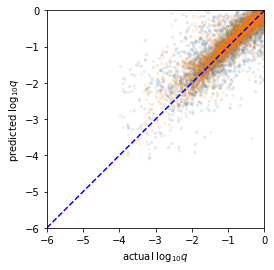

tensor([-1.1642, -0.4956, -0.3928, -0.3392, -0.4207, -1.1895, -0.3903, -0.1644,
        -0.1996, -1.4824], dtype=torch.float64)
[-1.2781354  -0.4898862  -0.3997078  -0.2895295  -0.31540892 -0.9742712
 -0.35071102 -0.19658735 -0.578302   -1.3397311 ]
mse of log10q:  0.11417786218451731
mse of rand log10q:  0.15830102990381925


In [34]:
import matplotlib.pyplot as plt
%matplotlib inline
# num=4096
plt.axis('square')
plt.xlim(-6, 0)
plt.ylim(-6, 0)
plt.xlabel(r'actual $\log_{10}q$')
plt.ylabel(r'predicted $\log_{10}q$')
plt.scatter(Y[:num, 2], pred_rand.numpy()[:num, 2], s=5, alpha=0.1)
plt.scatter(Y[:num, 2], pred.numpy()[:num, 2], s=5, alpha=0.1)
plt.plot(np.linspace(-6, 0), np.linspace(-6, 0), color='b', linestyle='dashed')
plt.show()
print(Y[:10, 2])
print(pred.numpy()[:10, 2])
print('mse of log10q: ', torch.mean((Y[:num, 2] -  pred.numpy()[:num, 2])**2, dim=0).detach().cpu().item())
print('mse of rand log10q: ', torch.mean((Y[:num, 2] -  pred_rand.numpy()[:num, 2])**2, dim=0).detach().cpu().item())

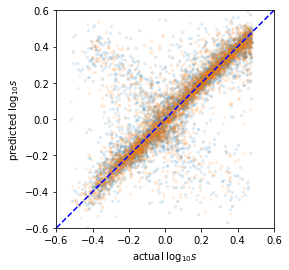

tensor([ 0.4741, -0.2005,  0.4423, -0.3065, -0.0105, -0.0435,  0.4580,  0.4070,
         0.4273, -0.1116], dtype=torch.float64)
[ 0.5279191  -0.19485839  0.36954108 -0.2861271   0.02570045 -0.04249968
  0.40702966  0.40157792  0.35378858 -0.15677536]
mse of log10s:  0.023350933568948365
mse of rand log10s:  0.032163734492334214


In [35]:
import matplotlib.pyplot as plt
%matplotlib inline
# num=4096
plt.axis('square')
plt.xlim(-0.6, 0.6)
plt.ylim(-0.6, 0.6)
plt.xlabel(r'actual $\log_{10}s$')
plt.ylabel(r'predicted $\log_{10}s$')
plt.scatter(Y[:num, 3], pred_rand.numpy()[:num, 3], s=5, alpha=0.1)
plt.scatter(Y[:num, 3], pred.numpy()[:num, 3], s=5, alpha=0.1)
plt.plot(np.linspace(-0.6, 0.6), np.linspace(-0.6, 0.6), color='b', linestyle='dashed')
plt.show()
print(Y[:10, 3])
print(pred.numpy()[:10, 3])
print('mse of log10s: ', torch.mean((Y[:num, 3] -  pred.numpy()[:num, 3])**2, dim=0).detach().cpu().item())
print('mse of rand log10s: ', torch.mean((Y[:num, 3] -  pred_rand.numpy()[:num, 3])**2, dim=0).detach().cpu().item())

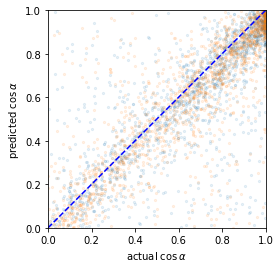

tensor([-0.8170,  0.1277,  0.0997, -0.9928, -0.7811,  0.7703, -0.4708, -0.9593,
         0.4358, -0.8743], dtype=torch.float64)
[-0.8317671   0.04934936  0.06265917 -1.0182316  -0.0235028   0.54783165
 -0.458868   -0.92249024  0.1195899  -0.8625575 ]
mse of cosa:  0.29159454007643654
mse of rand cosa:  0.3683186656608268


In [36]:
import matplotlib.pyplot as plt
%matplotlib inline
# num=4096
plt.axis('square')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel(r'actual $\cos\alpha$')
plt.ylabel(r'predicted $\cos\alpha$')
plt.scatter(Y[:num, 4], pred_rand.numpy()[:num, 4], s=5, alpha=0.1)
plt.scatter(Y[:num, 4], pred.numpy()[:num, 4], s=5, alpha=0.1)
plt.plot(np.linspace(0, 1), np.linspace(0, 1), color='b', linestyle='dashed')
plt.show()
print(Y[:10, 4])
print(pred.numpy()[:10, 4])
print('mse of cosa: ', torch.mean((Y[:num, 4] -  pred.numpy()[:num, 4])**2, dim=0).detach().cpu().item())
print('mse of rand cosa: ', torch.mean((Y[:num, 4] -  pred_rand.numpy()[:num, 4])**2, dim=0).detach().cpu().item())

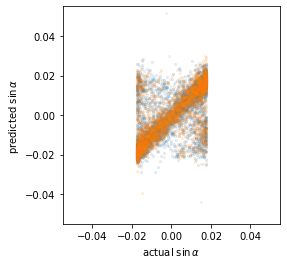

tensor([-0.0143,  0.0022,  0.0017, -0.0173, -0.0136,  0.0134, -0.0082, -0.0167,
         0.0076, -0.0153], dtype=torch.float64)
[-0.01578771  0.00476458 -0.00200701 -0.0237039  -0.00360025  0.0125601
 -0.00689221 -0.01785398  0.0086051  -0.01507254]
mse of sina:  0.00011528742940024696
mse of rand sina:  0.00012440374536101716


In [37]:
import matplotlib.pyplot as plt
%matplotlib inline
# num=4096
plt.axis('square')
# plt.xlim(0, 1)
# plt.ylim(0, 1)
plt.xlabel(r'actual $\sin\alpha$')
plt.ylabel(r'predicted $\sin\alpha$')
plt.scatter(Y[:num, 5], pred_rand.numpy()[:num, 5], s=5, alpha=0.1)
plt.scatter(Y[:num, 5], pred.numpy()[:num, 5], s=5, alpha=0.1)
# plt.plot(np.linspace(0, 1), np.linspace(0, 1), color='b', linestyle='dashed')
plt.show()
print(Y[:10, 5])
print(pred.numpy()[:10, 5])
print('mse of sina: ', torch.mean((Y[:num, 5] -  pred.numpy()[:num, 5])**2, dim=0).detach().cpu().item())
print('mse of rand sina: ', torch.mean((Y[:num, 5] -  pred_rand.numpy()[:num, 5])**2, dim=0).detach().cpu().item())

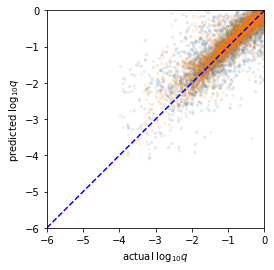

tensor([-1.1642, -0.4956, -0.3928, -0.3392, -0.4207, -1.1895, -0.3903, -0.1644,
        -0.1996, -1.4824], dtype=torch.float64)
[-1.2781354  -0.4898862  -0.3997078  -0.2895295  -0.31540892 -0.9742712
 -0.35071102 -0.19658735 -0.578302   -1.3397311 ]
mse of log10q:  0.11417786218451731
mse of rand log10q:  0.15830102990381925


In [38]:
import matplotlib.pyplot as plt
%matplotlib inline
# num=4096
plt.axis('square')
plt.xlim(-6, 0)
plt.ylim(-6, 0)
plt.xlabel(r'actual $\log_{10}q$')
plt.ylabel(r'predicted $\log_{10}q$')
plt.scatter(Y[:num, 2], pred_rand.numpy()[:num, 2], s=5, alpha=0.1)
plt.scatter(Y[:num, 2], pred.numpy()[:num, 2], s=5, alpha=0.1)
plt.plot(np.linspace(-6, 0), np.linspace(-6, 0), color='b', linestyle='dashed')
plt.show()
print(Y[:10, 2])
print(pred.numpy()[:10, 2])
print('mse of log10q: ', torch.mean((Y[:num, 2] -  pred.numpy()[:num, 2])**2, dim=0).detach().cpu().item())
print('mse of rand log10q: ', torch.mean((Y[:num, 2] -  pred_rand.numpy()[:num, 2])**2, dim=0).detach().cpu().item())

# UNet Locator and CNN Scaler

In [2]:
with h5py.File('/work/hmzhao/irregular-lc/roman-0-8dof.h5', mode='r') as dataset_file:
    Y = torch.tensor(dataset_file['Y'][...])
    X_even = torch.tensor(dataset_file['X_even'][...])
    X_rand = torch.tensor(dataset_file['X_random'][...])

In [3]:
# preprocess
nanind = torch.where(~torch.isnan(X_even[:, 0, 1]))[0]
# Y: t_0, t_E, u_0, rho, q, s, alpha, f_s
# Y = Y[:, [0, 1, -1]] # locator predicts t_0, t_E and f_s
Y[:, -1] = torch.log10(Y[:, -1])
std_Y = torch.tensor([1,])
# Y = Y / std_Y
Y = Y[nanind]
Y = Y[:, [0, 1, -1]]

# discard uncertainty bar
X_even = X_even[nanind]
X_rand = X_rand[nanind]

tensor([49.8670,  1.9257, -0.3953], dtype=torch.float64)


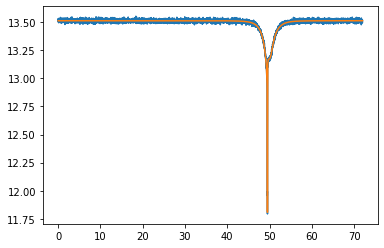

In [4]:
num = 933
print(Y[num])
plt.plot(X_rand[num, :, 0], X_rand[num, :, 1])
plt.plot(X_even[num, :, 0], X_even[num, :, 1])
plt.show()

In [6]:
from model.locator import Locator
import torchcde
import os

device = torch.device("cuda:9" if torch.cuda.is_available() else "cpu")

checkpt = torch.load('/work/hmzhao/experiments/locator/experiment_24294.ckpt', map_location='cpu')
ckpt_args = checkpt['args']
state_dict = checkpt['state_dict']

depth = 2; window_length = 1; 
train_logsig = torchcde.logsig_windows(X_even[:, :, :], depth, window_length=window_length)
train_coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(train_logsig)

output_dim = Y.shape[-1]
input_dim = train_logsig.shape[-1]
latent_dim = ckpt_args.latents

model = Locator(input_dim, latent_dim, output_dim, device).to(device)
model_dict = model.state_dict()

# 1. filter out unnecessary keys
state_dict = {k: v for k, v in state_dict.items() if k in model_dict}
# 2. overwrite entries in the existing state dict
model_dict.update(state_dict) 
# 3. load the new state dict
model.load_state_dict(state_dict)
model.to(device)

Locator(
  (unet): UNET_1D(
    (AvgPool1D1): AvgPool1d(kernel_size=(1,), stride=(5,), padding=(0,))
    (AvgPool1D2): AvgPool1d(kernel_size=(1,), stride=(25,), padding=(0,))
    (AvgPool1D3): AvgPool1d(kernel_size=(1,), stride=(125,), padding=(0,))
    (layer1): Sequential(
      (0): conbr_block(
        (conv1): Conv1d(1, 128, kernel_size=(7,), stride=(1,), padding=(3,))
        (bn): InstanceNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (relu): PReLU(num_parameters=1)
      )
      (1): re_block(
        (cbr1): conbr_block(
          (conv1): Conv1d(128, 128, kernel_size=(7,), stride=(1,), padding=(3,))
          (bn): InstanceNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
          (relu): PReLU(num_parameters=1)
        )
        (cbr2): conbr_block(
          (conv1): Conv1d(128, 128, kernel_size=(7,), stride=(1,), padding=(3,))
          (bn): InstanceNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track

In [7]:
from model.scaler import Scaler
import torchcde
import os

device_s = torch.device("cuda:9" if torch.cuda.is_available() else "cpu")

checkpt = torch.load('/work/hmzhao/experiments/scaler/experiment_73778.ckpt', map_location='cpu')
ckpt_args = checkpt['args']
state_dict = checkpt['state_dict']

depth = 2; window_length = 1; 
train_rand_logsig = torchcde.logsig_windows(X_rand[:, :, :2], depth, window_length=window_length)
train_rand_coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(train_rand_logsig)

output_dim = 1
input_dim = train_rand_logsig.shape[-1]
latent_dim = ckpt_args.latents

model_s = Scaler(input_dim, latent_dim, output_dim, device).to(device_s)
model_dict = model_s.state_dict()

# 1. filter out unnecessary keys
state_dict = {k: v for k, v in state_dict.items() if k in model_dict}
# 2. overwrite entries in the existing state dict
model_dict.update(state_dict) 
# 3. load the new state dict
model_s.load_state_dict(state_dict)
model_s.to(device)

Scaler(
  (initial): Sequential(
    (0): Sequential(
      (0): Linear(in_features=3, out_features=1024, bias=True)
      (1): PReLU(num_parameters=1)
      (2): Linear(in_features=1024, out_features=32, bias=True)
    )
  )
  (gate): PReLU(num_parameters=1)
  (cnn_featurizer): Sequential(
    (0): Conv1d(32, 256, kernel_size=(15,), stride=(2,), padding=(7,))
    (1): PReLU(num_parameters=1)
    (2): Conv1d(256, 512, kernel_size=(15,), stride=(2,), padding=(7,))
    (3): PReLU(num_parameters=1)
    (4): CNNResBlock(
      (linear1): Conv1d(512, 128, kernel_size=(1,), stride=(1,), padding_mode=replicate)
      (nonlinear1): PReLU(num_parameters=1)
      (linear2): Conv1d(128, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=replicate)
      (layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
    (5): CNNResBlock(
      (linear1): Conv1d(512, 128, kernel_size=(1,), stride=(1,), padding_mode=replicate)
      (nonlinear1): PReLU(num_parameters=1)
      (

In [8]:
# animation of locator
from tqdm.notebook import tqdm
import matplotlib.animation as animation
# fig, ax = plt.subplots()
num = 5
z = torch.zeros((1, 4000)).to(device)
model.eval()
model.animate = True
ims = []
lc = []
for i in tqdm(range(2, 100)):
    batch = X_even[[num], :(7200*i//100), :]
    batch_line = torchcde.hermite_cubic_coefficients_with_backward_differences(batch).float().to(device)
    pred, mse, z_pred = model(batch_line, z)
    lc.append((batch[:, :, 1], z_pred.detach().cpu()))

    # im = ax.plot(batch[:, :, 1], animated=True)
    # im.append(ax.plot(z_pred.detach().cpu(), animated=True))
    # ims.append(im)

# ani = animation.ArtistAnimation(fig, ims)
# plt.show()                
np.save('ani.npy', lc)   
model.animate = False         

  0%|          | 0/98 [00:00<?, ?it/s]

In [8]:
from tqdm.notebook import tqdm
num = 4096*2
batchsize = 128
pred = torch.zeros((num, 2))
pred_s = torch.zeros((num, 1))
pred_rand = torch.zeros((num, 2))
pred_rand_s = torch.zeros((num, 1))
z = torch.zeros((batchsize, 4000)).to(device)
model.eval()
model.threshold = 0.5
model_s.eval()
for i in tqdm(range(num // batchsize)):
    batch = train_coeffs[i*batchsize:i*batchsize+batchsize].float().to(device)
    batch_rand = train_rand_coeffs[i*batchsize:i*batchsize+batchsize].float().to(device)
    # batch_y = Y[i*batchsize:i*batchsize+batchsize].float().to(device)
    # rescaley = (batch_y / 72 * 4000).int()
    # left = rescaley[:, [0]] - 2*rescaley[:, [1]]
    # right = rescaley[:, [0]] + 2*rescaley[:, [1]]
    # z = torch.tile(torch.arange(0, 4000).unsqueeze(0), (len(batch_y), 1)).to(device)
    # z = ((z > left) * (z < right)).int()
    pred[i*batchsize:i*batchsize+batchsize] = model(batch, z)[0].detach().cpu()
    pred_s[i*batchsize:i*batchsize+batchsize] = model_s(batch).detach().cpu()
    pred_rand[i*batchsize:i*batchsize+batchsize] = model(batch_rand, z)[0].detach().cpu()
    pred_rand_s[i*batchsize:i*batchsize+batchsize] = model_s(batch_rand).detach().cpu()

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

/home/hmzhao/.conda/envs/ode-rnn/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


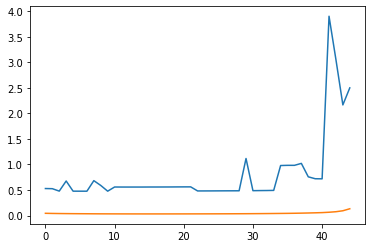

In [17]:
mse = []
for threshold in tqdm(np.arange(0.1, 1, 0.02)):
    model.threshold = threshold
    num = 4096
    batchsize = 128
    pred = torch.zeros((num, output_dim))
    z = torch.zeros((batchsize, 4000)).to(device)
    model.eval()
    for i in range(num // batchsize):
        batch = train_coeffs[i*batchsize:i*batchsize+batchsize].float().to(device)
        pred[i*batchsize:i*batchsize+batchsize] = model(batch, z)[0].detach().cpu()
    mse.append(torch.mean((Y[:num] -  pred.numpy()[:num])**2, dim=0).detach().cpu().numpy())
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(mse)
plt.show()

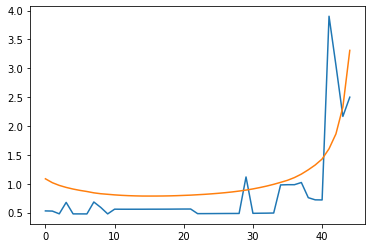

In [20]:
plt.plot(np.array(mse)[:, 0])
plt.plot(np.array(mse)[:, 1]*25)
plt.show()

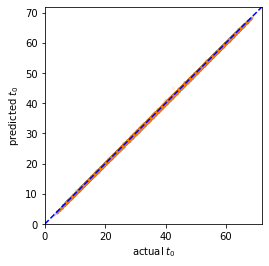

tensor([42.3968, 52.4625, 28.9251, 20.2984, 31.0619, 24.4573, 52.9314, 58.4026,
        55.2998, 15.6580], dtype=torch.float64)
[42.41973  52.61008  28.982244 20.144445 31.205519 24.466007 52.978718
 58.479355 55.33705  15.670534]
mse of t_0  0.014193883119712605
mse of t_0  0.019209479956106112


In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
# num=4096
plt.axis('square')
plt.xlim(0, 72)
plt.ylim(0, 72)
plt.xlabel(r'actual $t_0$')
plt.ylabel(r'predicted $t_0$')
plt.scatter(Y[:num, 0], pred_rand.numpy()[:num, 0], s=5, alpha=0.1)
plt.scatter(Y[:num, 0], pred.numpy()[:num, 0], s=5, alpha=0.1)
plt.plot(np.linspace(0, 72), np.linspace(0, 72), color='b', linestyle='dashed')
plt.show()
print(Y[:10, 0])
print(pred.numpy()[:10, 0])
print('mse of t_0 ', torch.mean((Y[:num, 0] -  pred.numpy()[:num, 0])**2, dim=0).detach().cpu().item())
print('mse of t_0 ', torch.mean((Y[:num, 0] -  pred_rand.numpy()[:num, 0])**2, dim=0).detach().cpu().item())

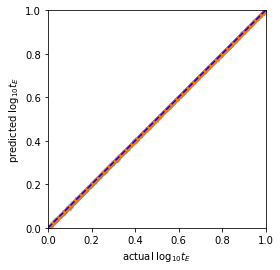

tensor([6.7652, 4.5947, 3.6902, 1.5346, 4.6416, 2.5067, 4.6210, 4.2347, 2.4163,
        5.1449], dtype=torch.float64)
[6.7975254 4.607047  3.6965475 1.5412176 4.628357  2.5217528 4.637007
 4.237114  2.4315844 5.143135 ]
mse of t_E:  0.0005098805406767355
mse of rand t_E:  0.0005680657808344906


In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
# num=4096
plt.axis('square')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel(r'actual $\log_{10}t_E$')
plt.ylabel(r'predicted $\log_{10}t_E$')
plt.scatter(np.log10(Y[:num, 1]), np.log10(pred_rand.numpy()[:num, 1]), s=5, alpha=0.1)
plt.scatter(np.log10(Y[:num, 1]), np.log10(pred.numpy()[:num, 1]), s=5, alpha=0.1)
plt.plot(np.linspace(0, 1), np.linspace(0, 1), color='b', linestyle='dashed')
plt.show()
print(Y[:10, 1])
print(pred.numpy()[:10, 1])
print('mse of t_E: ', torch.mean((Y[:num, 1] -  pred.numpy()[:num, 1])**2, dim=0).detach().cpu().item())
print('mse of rand t_E: ', torch.mean((Y[:num, 1] -  pred_rand.numpy()[:num, 1])**2, dim=0).detach().cpu().item())

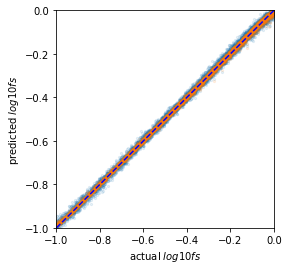

tensor([-0.8989, -0.5394, -0.1018, -0.3560, -0.8361, -0.6228, -0.3883, -0.3019,
        -0.5866, -0.5470], dtype=torch.float64)
[-0.89132315 -0.54052705 -0.0877416  -0.34990373 -0.83061105 -0.613287
 -0.39246818 -0.29464346 -0.57045025 -0.5497681 ]
mse of log_10 f_s:  5.101823795505726e-05
mse of rand log_10 f_s:  0.00017914117654747527


In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
# num=4096
plt.axis('square')
plt.xlim(-1, 0)
plt.ylim(-1, 0)
plt.xlabel(r'actual $log10fs$')
plt.ylabel(r'predicted $log10fs$')
plt.scatter(Y[:num, 2], pred_rand_s.numpy()[:num, 0], s=5, alpha=0.1)
plt.scatter(Y[:num, 2], pred_s.numpy()[:num, 0], s=5, alpha=0.1)
plt.plot(np.linspace(-1, 0), np.linspace(-1, 0), color='b', linestyle='dashed')
plt.show()
print(Y[:10, 2])
print(pred_s.numpy()[:10, 0])
print('mse of log_10 f_s: ', torch.mean((Y[:num, 2] -  pred_s.numpy()[:num, 0])**2, dim=0).detach().cpu().item())
print('mse of rand log_10 f_s: ', torch.mean((Y[:num, 2] -  pred_rand_s.numpy()[:num, 0])**2, dim=0).detach().cpu().item())

In [25]:
((Y[:num, 2] -  pred_s.numpy()[:num, 0])**2).argmax()

tensor(933)

In [9]:
with h5py.File('/work/hmzhao/irregular-lc/random-even-batch-1.h5', mode='r') as dataset_file:
    Y = torch.tensor(dataset_file['Y'][...])
    X_even = torch.tensor(dataset_file['X_even'][...])

In [10]:
# normalize
Y[:, 3:6] = torch.log10(Y[:, 3:6])
Y[:, 6] = torch.cos(Y[:, 6] / 180 * np.pi)
Y = torch.hstack([Y, torch.sin(Y[:, [6]] / 180 * np.pi)])
Y = Y[:, 2:]
# mean_y = torch.mean(Y, axis=0)
# std_y = torch.std(Y, axis=0)
# std_mask = (std_y==0)
# std_y[std_mask] = 1
# print(f'Y mean: {mean_y}\nY std: {std_y}')
# Y = (Y - mean_y) / std_y
# print(f'normalized Y mean: {torch.mean(Y)}\nY std: {torch.mean(torch.std(Y, axis=0)[~std_mask])}')

mean_x_even = 14.5
std_x_even = 0.2
X_even[:, :, 1] = (X_even[:, :, 1] - mean_x_even) / std_x_even
print(f'normalized X mean: {torch.mean(X_even[:, :, 1])}\nX std: {torch.mean(torch.std(X_even[:, :, 1], axis=0))}')
X_even[:, :, 0] = X_even[:, :, 0] / 200

# X_even[:, :, 1] = (22-2.5*torch.log10(X_even[:, :, 1]*1000)-14.5)/0.2
# print(f'normalized X mean: {torch.mean(X_even[:, :, 1])}\nX std: {torch.mean(torch.std(X_even[:, :, 1], axis=0))}')
# X_even[:, :, 0] = X_even[:, :, 0] / 4


# Y = Y[:, 4:6]

normalized X mean: -2.0646457695410256
X std: 1.1980351190055827


tensor([ 0.1965, -3.0041, -1.1895, -0.0435,  0.7703,  0.0134],
       dtype=torch.float64)


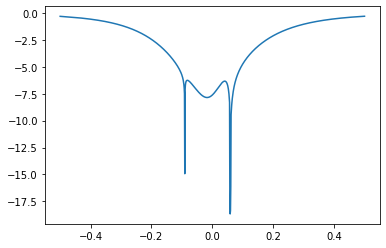

In [11]:
print(Y[5])
plt.plot(X_even[5, :, 0], X_even[5, :, 1])

# CDE Regression

In [14]:
from model.encoder_cde import CDEEncoder
import torchcde
import os

device = torch.device("cuda:8" if torch.cuda.is_available() else "cpu")

checkpt = torch.load('/work/hmzhao/experiments/experiment_12326.ckpt', map_location='cpu')
ckpt_args = checkpt['args']
state_dict = checkpt['state_dict']

depth = 3; window_length = 10; window_length_rand = 2
train_logsig = torchcde.logsig_windows(X_even[:, :, :], depth, window_length=window_length)
train_coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(train_logsig)
# train_coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(X_even)

output_dim = Y.shape[-1]
input_dim = train_logsig.shape[-1]
# input_dim = X_even.shape[-1]
latent_dim = ckpt_args.latents

model = CDEEncoder(input_dim, latent_dim, output_dim).to(device)
model_dict = model.state_dict()

# 1. filter out unnecessary keys
state_dict = {k: v for k, v in state_dict.items() if k in model_dict}
# 2. overwrite entries in the existing state dict
model_dict.update(state_dict) 
# 3. load the new state dict
model.load_state_dict(state_dict)
model.to(device)

CDEEncoder(
  (cde_func): CDEFunc(
    (linear1): Linear(in_features=32, out_features=1024, bias=True)
    (ReLU1): ReLU()
    (resblocks): Sequential(
      (0): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): ReLU()
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (1): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): ReLU()
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (2): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): ReLU()
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
    )
    (ReLU2): ReLU()
    (linear2): Linear(in_features=1024, out_features=160, bias=True)
    (tanh): Tanh()
    (linear3): Linear(in_features=160, out_features=160, bias=True)
  )
  (initial): Sequential(
    (0): Sequential

In [15]:
from tqdm import tqdm
num = 4096*2
batchsize = 128
pred = torch.zeros((num, output_dim))
model.eval()
for i in tqdm(range(num // batchsize)):
    batch = train_coeffs[i*batchsize:i*batchsize+batchsize].float().to(device)
    pred[i*batchsize:i*batchsize+batchsize] = model(batch).detach().cpu()

100%|██████████| 64/64 [03:55<00:00,  3.68s/it]


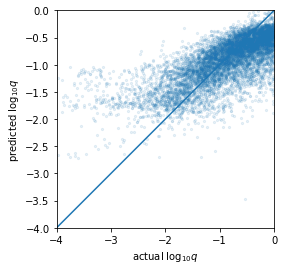

logq


In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.axis('square')
plt.xlim(-4, 0)
plt.ylim(-4, 0)
plt.xlabel(r'actual $\log_{10} q$')
plt.ylabel(r'predicted $\log_{10} q$')
plt.scatter(Y[:num, 2], pred.numpy()[:num, 2], s=5, alpha=0.1)
plt.plot(np.linspace(-4, 0), np.linspace(-4, 0))
plt.show()
print('logq')

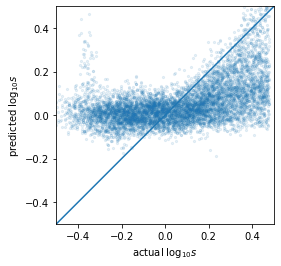

logs


In [20]:
# num = 4096*5
plt.axis('square')
plt.xlim(-0.5, 0.5)
plt.ylim(-0.5, 0.5)
plt.xlabel(r'actual $\log_{10} s$')
plt.ylabel(r'predicted $\log_{10} s$')
plt.scatter(Y[:num, 3], pred.numpy()[:, 3], s=5, alpha=0.1)
plt.plot(np.linspace(-0.5, 0.5), np.linspace(-0.5, 0.5))
plt.show()
print('logs')

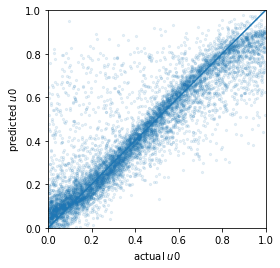

u0


In [24]:
# num = 4096*5
plt.axis('square')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel(r'actual $u0$')
plt.ylabel(r'predicted $u0$')
plt.scatter(Y[:num, 0], pred.numpy()[:, 0], s=5, alpha=0.1)
plt.plot(np.linspace(0, 1), np.linspace(0, 1))
plt.show()
print('u0')

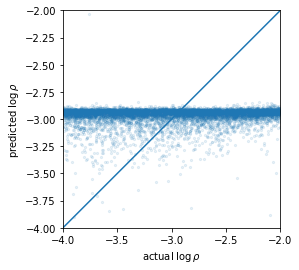

logrho


In [26]:
# num = 4096*5
plt.axis('square')
plt.xlim(-4, -2)
plt.ylim(-4, -2)
plt.xlabel(r'actual $\log\rho$')
plt.ylabel(r'predicted $\log\rho$')
plt.scatter(Y[:num, 1], pred.numpy()[:, 1], s=5, alpha=0.1)
plt.plot(np.linspace(-4, -2), np.linspace(-4, -2))
plt.show()
print('logrho')

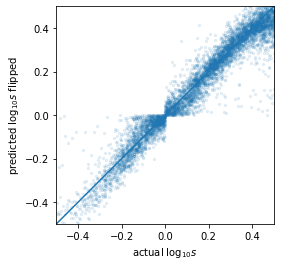

logs flipped


In [68]:
plt.axis('square')
plt.xlim(-0.5, 0.5)
plt.ylim(-0.5, 0.5)
plt.xlabel(r'actual $\log_{10} s$')
plt.ylabel(r'predicted $\log_{10} s$ flipped')
plt.scatter(Y[:num, 1]/np.log(10), ((Y[:num, 1]*pred.numpy()[:, 1]<0)*(-2)+1)*pred.numpy()[:, 1]/np.log(10), s=5, alpha=0.1)
plt.plot(np.linspace(-0.5, 0.5), np.linspace(-0.5, 0.5))
plt.show()
print('logs flipped')

In [36]:
torch.mean((Y[:num, 0] / np.log(10) - pred[:, 0] / np.log(10))**2)

tensor(0.0199, dtype=torch.float64)

In [37]:
# orig_sample_Y = Y[:num] * std_y + mean_y
# orig_sample_pred = pred.detach().cpu() * std_y + mean_y

In [38]:
# u0 = orig_sample_Y[:, 2]
# log10q = orig_sample_Y[:, 4] / np.log(10)
# log10s = orig_sample_Y[:, 5] / np.log(10)
# alpha = orig_sample_Y[:, 6]
# u0cosalpha = u0 * np.cos(alpha/180*np.pi)
# u0sinalpha = u0 * np.sin(alpha/180*np.pi)

log10q = Y[:num, 0] / np.log(10)
log10s = Y[:num, 1] / np.log(10)

# u0_pred = orig_sample_pred[:, 2]
# log10q_pred = orig_sample_pred[:, 4] / np.log(10)
# log10s_pred = orig_sample_pred[:, 5] / np.log(10)
# alpha_pred = orig_sample_pred[:, 6]
# u0cosalpha_pred = u0_pred * np.cos(alpha_pred/180*np.pi)
# u0sinalpha_pred = u0_pred * np.sin(alpha_pred/180*np.pi)
log10q_pred = pred[:num, 0] / np.log(10)
log10s_pred = pred[:num, 1] / np.log(10)
log10s_pred_fl = ((Y[:num, 1]*pred.numpy()[:, 1]<0)*(-2)+1)*pred.numpy()[:, 1]/np.log(10)

In [39]:
mse_log10q = torch.mean((log10q - log10q_pred)**2)
mse_log10s = torch.mean((log10s - log10s_pred)**2)
mse_log10s_fl = torch.mean((log10s - log10s_pred_fl)**2)
# mse_u0cos = torch.mean((u0cosalpha - u0cosalpha_pred)**2)
# mse_u0sin = torch.mean((u0sinalpha - u0sinalpha_pred)**2)
# mse_u0 = torch.mean((u0 - u0_pred)**2)
# mse_alpha = torch.mean((alpha - alpha_pred)**2)
print(f"mse of log10q: {mse_log10q}, mse of log10s: {mse_log10s}, mse of log10s flipped: {mse_log10s_fl}")
# print(f"mse of u0cos_alpha: {mse_u0cos}, mse of u0sin_alpha: {mse_u0sin}")
# print(f"mse of u0: {mse_u0}, mse of alpha: {mse_alpha}")

mse of log10q: 0.01994311612243387, mse of log10s: 0.004686244408872796, mse of log10s flipped: 0.00331549248007528


## irregular

In [11]:
with h5py.File('/work/hmzhao/irregular-lc/random-even-batch-1.h5', mode='r') as dataset_file:
    X_rand = torch.tensor(dataset_file['X_random'][...])

In [12]:
X_rand = X_rand[:, :, :2]
X_rand[:, :, 1] = (X_rand[:, :, 1] - mean_x_even) / std_x_even
X_rand[:, :, 0] = X_rand[:, :, 0] / 200
print(f'normalized X mean: {torch.mean(X_rand[:, :, 1])}\nX std: {torch.mean(torch.std(X_rand[:, :, 1], axis=0))}')

normalized X mean: -2.069411861275131
X std: 1.2975609646921018


tensor([-1.1411, -0.4616], dtype=torch.float64)


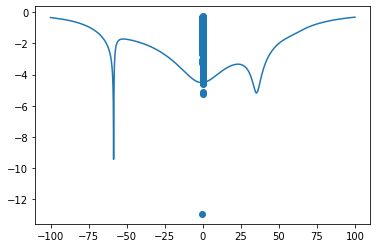

In [13]:
num = 1
print(Y[num])
plt.scatter(X_rand[num, :, 0], X_rand[num, :, 1])
plt.plot(X_even[num, :, 0], X_even[num, :, 1])

In [25]:
num = 4096*2
batchsize = 128
train_logsig_rand = torchcde.logsig_windows(X_rand[:num, :, :], depth, window_length=window_length_rand)
train_rand_coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(train_logsig_rand)

In [26]:
from tqdm import tqdm
pred_ir = torch.zeros((num, output_dim))
model.eval()
for i in tqdm(range(num // batchsize)):
    batch = train_rand_coeffs[i*batchsize:i*batchsize+batchsize].float().to(device)
    pred_ir[i*batchsize:i*batchsize+batchsize] = model(batch).detach().cpu()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [07:31<00:00,  7.05s/it]


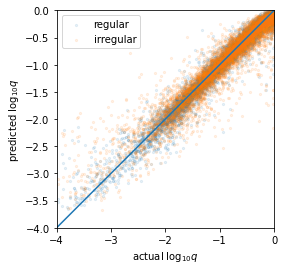

logq


In [74]:
num = 4096*2
plt.axis('square')
plt.xlim(-4, 0)
plt.ylim(-4, 0)
plt.xlabel(r'actual $\log_{10} q$')
plt.ylabel(r'predicted $\log_{10} q$')
plt.scatter(Y[:num, 0]/np.log(10), pred.numpy()[:num, 0]/np.log(10), label='regular', s=5, alpha=0.1)
plt.scatter(Y[:num, 0]/np.log(10), pred_ir.numpy()[:num, 0]/np.log(10), label='irregular', s=5, alpha=0.1)
plt.plot(np.linspace(-4, 0), np.linspace(-4, 0))
plt.legend()
plt.show()
print('logq')

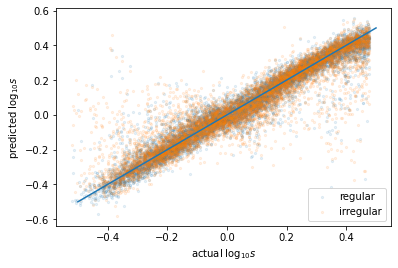

logs


In [73]:
plt.xlabel(r'actual $\log_{10} s$')
plt.ylabel(r'predicted $\log_{10} s$')
plt.scatter(Y[:num, 1]/np.log(10), pred.numpy()[:num, 1]/np.log(10), label='regular', s=5, alpha=0.1)
plt.scatter(Y[:num, 1]/np.log(10), pred_ir.numpy()[:num, 1]/np.log(10), label='irregular', s=5, alpha=0.1)
plt.plot(np.linspace(-0.5, 0.5), np.linspace(-0.5, 0.5))
plt.legend()
plt.show()
print('logs')

In [24]:
# orig_sample_pred_ir = pred_ir.detach().cpu() * std_y + mean_y

# u0_pred_ir = orig_sample_pred_ir[:, 2]
# log10q_pred_ir = orig_sample_pred_ir[:, 4] / np.log(10)
# log10s_pred_ir = orig_sample_pred_ir[:, 5] / np.log(10)
# alpha_pred_ir = orig_sample_pred_ir[:, 6]
# u0cosalpha_pred_ir = u0_pred_ir * np.cos(alpha_pred_ir/180*np.pi)
# u0sinalpha_pred_ir = u0_pred_ir * np.sin(alpha_pred_ir/180*np.pi)

log10q_pred_ir = pred_ir[:, 0] / np.log(10)
log10s_pred_ir = pred_ir[:, 1] / np.log(10)

In [25]:
mse_log10q_ir = torch.mean((log10q - log10q_pred_ir)**2)
mse_log10s_ir = torch.mean((log10s - log10s_pred_ir)**2)
# mse_u0cos_ir = torch.mean((u0cosalpha - u0cosalpha_pred_ir)**2)
# mse_u0sin_ir = torch.mean((u0sinalpha - u0sinalpha_pred_ir)**2)
# mse_u0_ir = torch.mean((u0 - u0_pred_ir)**2)
# mse_alpha_ir = torch.mean((alpha - alpha_pred_ir)**2)
print('regular:')
print(f"mse of log10q: {mse_log10q}, mse of log10s: {mse_log10s}")
# print(f"mse of u0cos_alpha: {mse_u0cos}, mse of u0sin_alpha: {mse_u0sin}")
# print(f"mse of u0: {mse_u0}, mse of alpha: {mse_alpha}")
print('irregular:')
print(f"mse of log10q: {mse_log10q_ir}, mse of log10s: {mse_log10s_ir}")
# print(f"mse of u0cos_alpha: {mse_u0cos_ir}, mse of u0sin_alpha: {mse_u0sin_ir}")
# print(f"mse of u0: {mse_u0_ir}, mse of alpha: {mse_alpha_ir}")

regular:
mse of log10q: 0.022074238500991727, mse of log10s: 0.00522088770891074
irregular:
mse of log10q: 0.05360115068172922, mse of log10s: 0.009940048005258264


Ground Truth: [-2.68066621  1.09161808]
Reg Pred [-3.0919013  1.002171 ]
Reg MSE [0.03189691 0.00150904]
Irr Pred [-3.318852   1.0125068]
Irr MSE [0.07681794 0.00118044]


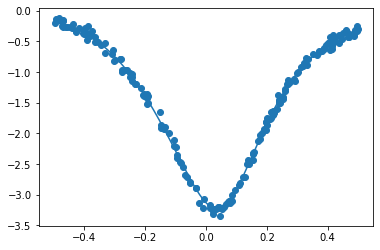

In [26]:
num = 0
print('Ground Truth:', Y[num].numpy())
print('Reg Pred', pred[num].numpy())
print('Reg MSE', ((Y[num]/np.log(10)- pred[num]/np.log(10))**2).numpy())
print('Irr Pred', pred_ir[num].numpy())
print('Irr MSE', ((Y[num]/np.log(10)- pred_ir[num]/np.log(10))**2).numpy())
plt.scatter(X_rand[num, :, 0], X_rand[num, :, 1])
plt.plot(X_even[num, :, 0], X_even[num, :, 1])

Ground Truth: [-0.49557534 -0.20045365]
Reg Pred [-0.5124909  -0.19459671]
Reg MSE [2.86137265e-04 3.43037549e-05]
Irr Pred [-0.4695378  -0.16875184]
Irr MSE [0.00067795 0.001005  ]


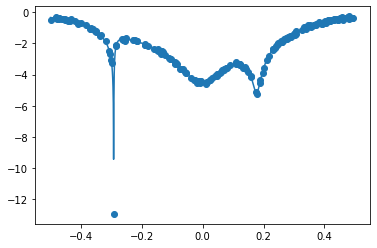

In [27]:
num = 1
print('Ground Truth:', Y[num].numpy()/np.log(10))
print('Reg Pred', pred[num].numpy()/np.log(10))
print('Reg MSE', ((Y[num]/np.log(10)- pred[num]/np.log(10))**2).numpy())
print('Irr Pred', pred_ir[num].numpy()/np.log(10))
print('Irr MSE', ((Y[num]/np.log(10)- pred_ir[num]/np.log(10))**2).numpy())
plt.scatter(X_rand[num, :, 0], X_rand[num, :, 1])
plt.plot(X_even[num, :, 0], X_even[num, :, 1])

In [28]:
torch.argmax(((Y[:4096*2] - pred)**2)[:,0])

tensor(6461)

Ground Truth: [-3.85518735 -0.0100205 ]
Reg Pred [-2.3501029e+00 -1.0784054e-03]
Reg MSE [2.26527920e+00 7.99610904e-05]
Irr Pred [-1.673176  -0.0958605]
Irr MSE [4.76117332 0.0073685 ]


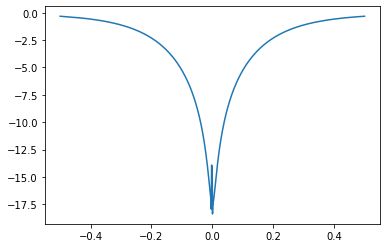

In [29]:
num = 6461
print('Ground Truth:', Y[num].numpy()/np.log(10))
print('Reg Pred', pred[num].numpy()/np.log(10))
print('Reg MSE', ((Y[num]/np.log(10)- pred[num]/np.log(10))**2).numpy())
print('Irr Pred', pred_ir[num].numpy()/np.log(10))
print('Irr MSE', ((Y[num]/np.log(10)- pred_ir[num]/np.log(10))**2).numpy())
# plt.scatter(X_rand[num, :, 0], X_rand[num, :, 1])
plt.plot(X_even[num, :, 0], X_even[num, :, 1])

In [30]:
torch.argmax(((Y[:4096*2] - pred)**2)[:,1])

tensor(1412)

Ground Truth: [-1.09113109 -0.50749415]
Reg Pred [-1.7544608  0.3015215]
Reg MSE [0.44000632 0.65450634]
Irr Pred [-2.0741465   0.23478006]
Irr MSE [0.96631932 0.550971  ]


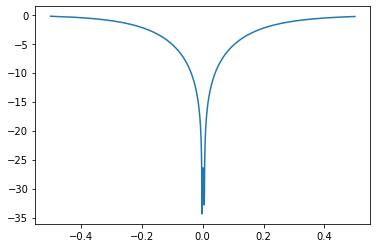

In [32]:
num = 1412
print('Ground Truth:', Y[num].numpy()/np.log(10))
print('Reg Pred', pred[num].numpy()/np.log(10))
print('Reg MSE', ((Y[num]/np.log(10)- pred[num]/np.log(10))**2).numpy())
print('Irr Pred', pred_ir[num].numpy()/np.log(10))
print('Irr MSE', ((Y[num]/np.log(10)- pred_ir[num]/np.log(10))**2).numpy())
# plt.scatter(X_rand[num, :, 0], X_rand[num, :, 1])
plt.plot(X_even[num, :, 0], X_even[num, :, 1])

Ground Truth: [-0.0272697  -0.45959017]
Reg Pred [-0.7392516  -0.36684895]
Reg MSE [0.50691824 0.00860093]
Irr Pred [-2.389151    0.05758382]
Irr MSE [5.57848372 0.26746894]


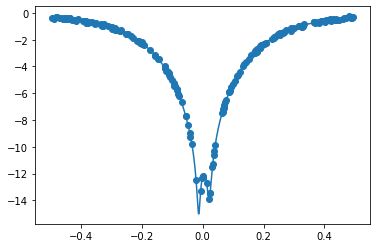

In [38]:
num = torch.argmax(((Y[:4096*2] - pred_ir)**2)[:,0])
print('Ground Truth:', Y[num].numpy()/np.log(10))
print('Reg Pred', pred[num].numpy()/np.log(10))
print('Reg MSE', ((Y[num]/np.log(10)- pred[num]/np.log(10))**2).numpy())
print('Irr Pred', pred_ir[num].numpy()/np.log(10))
print('Irr MSE', ((Y[num]/np.log(10)- pred_ir[num]/np.log(10))**2).numpy())
# plt.scatter(X_rand[num, :, 0], X_rand[num, :, 1])
plt.plot(X_even[num, :, 0], X_even[num, :, 1])
plt.scatter(X_rand[num, :, 0], X_rand[num, :, 1])

Ground Truth: [-0.25503131 -0.47437001]
Reg Pred [-0.36345115 -0.33493036]
Reg MSE [0.01175486 0.01944341]
Irr Pred [-1.7012384  0.3931868]
Irr MSE [2.09151493 0.75265482]


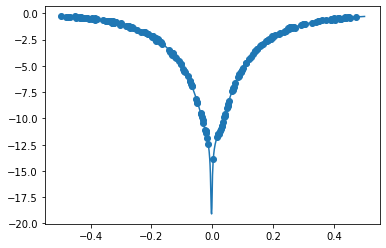

In [39]:
num = torch.argmax(((Y[:4096*2] - pred_ir)**2)[:,1])
print('Ground Truth:', Y[num].numpy()/np.log(10))
print('Reg Pred', pred[num].numpy()/np.log(10))
print('Reg MSE', ((Y[num]/np.log(10)- pred[num]/np.log(10))**2).numpy())
print('Irr Pred', pred_ir[num].numpy()/np.log(10))
print('Irr MSE', ((Y[num]/np.log(10)- pred_ir[num]/np.log(10))**2).numpy())
# plt.scatter(X_rand[num, :, 0], X_rand[num, :, 1])
plt.plot(X_even[num, :, 0], X_even[num, :, 1])
plt.scatter(X_rand[num, :, 0], X_rand[num, :, 1])

# LZR's results
## mse on ideal

loss(mse): 0.1

log10q: 0.3^2=0.09, log10s: 0.18^2=0.0324

## mse on realistic

loss(mse): 0.1

log10q: 0.0846, log10s: 0.0176

u0cos: 0.037, u0sin: 0.040

u0: 0.0176, alpha: 7441.306

# Generative ODE

In [5]:
from model.gen_ode import GenODE

device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
input_dim = Y.shape[-1]
output_dim = X_even.shape[-1] - 1

checkpt = torch.load('/work/hmzhao/experiments/experiment_91672.ckpt')
ckpt_args = checkpt['args']
state_dict = checkpt['state_dict']

model = GenODE(ckpt_args, input_dim, output_dim, device).to(device)
model_dict = model.state_dict()

# 1. filter out unnecessary keys
state_dict = {k: v for k, v in state_dict.items() if k in model_dict}
# 2. overwrite entries in the existing state dict
model_dict.update(state_dict) 
# 3. load the new state dict
model.load_state_dict(state_dict)
model.to(device)

GenODE(
  (aug_net): Sequential(
    (0): Sequential(
      (0): Linear(in_features=7, out_features=256, bias=True)
      (1): Tanh()
      (2): Linear(in_features=256, out_features=256, bias=True)
    )
    (1): ResBlock(
      (linear1): Linear(in_features=256, out_features=1024, bias=True)
      (nonlinear1): Tanh()
      (linear2): Linear(in_features=1024, out_features=256, bias=True)
      (nonlinear2): Tanh()
      (linear3): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): ResBlock(
      (linear1): Linear(in_features=256, out_features=1024, bias=True)
      (nonlinear1): Tanh()
      (linear2): Linear(in_features=1024, out_features=256, bias=True)
      (nonlinear2): Tanh()
      (linear3): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): ResBlock(
      (linear1): Linear(in_features=256, out_features=1024, bias=True)
      (nonlinear1): Tanh()
      (linear2): Linear(in_features=1024, out_features=256, bias=True)
      (nonlinear2): Tanh()

In [24]:
model.eval()
num = 9
pred = model(torch.tensor(Y[num].reshape(1, -1)).float().to(device), torch.tensor(X_even[0, :, 0]).float().to(device))

/var/tmp/pbs.76146.metis/ipykernel_2237054/2281277329.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = model(torch.tensor(Y[num].reshape(1, -1)).float().to(device), torch.tensor(X_even[0, :, 0]).float().to(device))


tensor([ 0.0000, 50.0000,  1.8059, -0.8079,  0.0583,  0.9828, -1.4816],
       dtype=torch.float64)


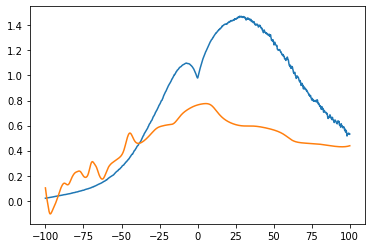

In [25]:
print(Y[num])
plt.plot(X_even[num, :, 0], X_even[num, :, 1])
plt.plot(X_even[num, :, 0], pred.detach().cpu().numpy().flatten())

In [26]:
latent = model.aug_net(torch.tensor(Y[num].reshape(1, -1)).float().to(device))
print(latent)

tensor([[ 0.3719,  0.5745, -0.5689, -0.7571, -0.3540, -0.3572, -0.5003,  0.0472,
         -0.4456, -0.8231,  0.0650, -0.1645, -0.0868, -0.0801,  0.0713,  0.4275,
          0.1516,  0.3267, -0.3136, -0.2969,  0.2027, -0.5207, -0.5530,  0.4291,
          0.1795,  0.7403,  0.0014,  0.6046, -0.4481, -0.0197,  0.3870,  0.1702]],
       device='cuda:2', grad_fn=<TanhBackward>)


/var/tmp/pbs.76146.metis/ipykernel_2237054/3264624822.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latent = model.aug_net(torch.tensor(Y[num].reshape(1, -1)).float().to(device))


In [27]:
initial_grad = model.ode_func(torch.tensor(-100).to(device), model.aug_net(torch.tensor(Y[num].reshape(1, -1)).float().to(device)))
print(initial_grad)

tensor([[ 0.6530, -0.0379, -0.8157, -0.6468, -0.0016,  0.4780, -0.6244,  0.7381,
         -0.3112, -0.7349, -0.6113, -0.1776,  0.2895,  0.5952,  0.1046, -0.0942,
          0.5388,  0.1250, -0.4205, -0.4357,  0.1152, -0.4637,  0.3835, -0.2316,
         -0.0043,  0.0744,  0.5310, -0.1046,  0.2542,  0.4332, -0.1092,  0.8952]],
       device='cuda:2', grad_fn=<TanhBackward>)


/var/tmp/pbs.76146.metis/ipykernel_2237054/837117711.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  initial_grad = model.ode_func(torch.tensor(-100).to(device), model.aug_net(torch.tensor(Y[num].reshape(1, -1)).float().to(device)))


In [28]:
from torchdiffeq import odeint
sol = odeint(model.ode_func, latent, torch.tensor(X_even[0, :, 0]).float().to(device), method="dopri5",
            rtol=1e-7, atol=1e-9)

/var/tmp/pbs.76146.metis/ipykernel_2237054/3534019619.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sol = odeint(model.ode_func, latent, torch.tensor(X_even[0, :, 0]).float().to(device), method="dopri5",


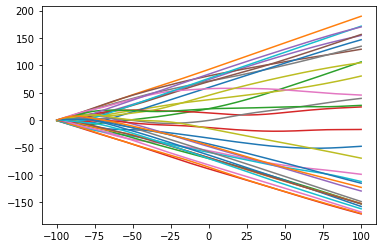

In [29]:
plt.plot(X_even[0, :, 0], sol.squeeze(1).detach().cpu())
plt.show()